![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Proyecto 2 - Clasificación de género de películas

El propósito de este proyecto es que puedan poner en práctica, en sus respectivos grupos de trabajo, sus conocimientos sobre técnicas de preprocesamiento, modelos predictivos de NLP, y la disponibilización de modelos. Para su desarrollo tengan en cuenta las instrucciones dadas en la "Guía del proyecto 2: Clasificación de género de películas"

**Entrega**: La entrega del proyecto deberán realizarla durante la semana 8. Sin embargo, es importante que avancen en la semana 7 en el modelado del problema y en parte del informe, tal y como se les indicó en la guía.

Para hacer la entrega, deberán adjuntar el informe autocontenido en PDF a la actividad de entrega del proyecto que encontrarán en la semana 8, y subir el archivo de predicciones a la [competencia de Kaggle](https://www.kaggle.com/t/2c54d005f76747fe83f77fbf8b3ec232).

## Datos para la predicción de género en películas

![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/moviegenre.png)

En este proyecto se usará un conjunto de datos de géneros de películas. Cada observación contiene el título de una película, su año de lanzamiento, la sinopsis o plot de la película (resumen de la trama) y los géneros a los que pertenece (una película puede pertenercer a más de un género). Por ejemplo:
- Título: 'How to Be a Serial Killer'
- Plot: 'A serial killer decides to teach the secrets of his satisfying career to a video store clerk.'
- Generos: 'Comedy', 'Crime', 'Horror'

La idea es que usen estos datos para predecir la probabilidad de que una película pertenezca, dada la sinopsis, a cada uno de los géneros.

Agradecemos al profesor Fabio González, Ph.D. y a su alumno John Arevalo por proporcionar este conjunto de datos. Ver https://arxiv.org/abs/1702.01992

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 56.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 72.9 MB/s eta 0:00:00


In [4]:
# Importación librerías
import pandas as pd
import os
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModel
from sklearn.preprocessing import MultiLabelBinarizer

In [5]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)

In [6]:
dataTraining

,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6
...,...,...,...,...,...
8417,2010,Our Family Wedding,""" our marriage , their wedding . "" it ' s l...","['Comedy', 'Romance']",4.9
1592,1984,Conan the Destroyer,"the wandering barbarian , conan , alongside ...","['Action', 'Adventure', 'Fantasy']",5.8
1723,1955,Kismet,"like a tale spun by scheherazade , kismet fol...","['Adventure', 'Musical', 'Fantasy', 'Comedy', ...",6.4
7605,1982,The Secret of NIMH,"mrs . brisby , a widowed mouse , lives in a...","['Animation', 'Adventure', 'Drama', 'Family', ...",7.6


In [7]:
np.random.seed(42)
tf.random.set_seed(42)

print(dataTraining.shape)
print(dataTesting.shape)

(7895, 5)
(3383, 3)


In [8]:
df = dataTraining

# Importamos los datos (asegúrate de tener el archivo correcto y la ruta correcta)
# Este es un ejemplo y los nombres de las columnas pueden variar

# Transformamos los géneros a un formato que se pueda usar para entrenar la red neuronal
genres = df['genres'].apply(lambda x: eval(x)) 

# Aquí binarizamos las múltiples etiquetas de género de una película
mlb = MultiLabelBinarizer()
encoded_genres = mlb.fit_transform(genres)

In [9]:
df['plot'] = df['plot'].apply(lambda x: x.lower())
df['title'] = df['title'].apply(lambda x: x.lower())
df['X'] = df['title'] + ': ' + df['plot']

In [ ]:
# Se hace split de los datos teniendo en cuenta únicamente la columna en la que se encuentra la descripción del plot de la película.
# El plot es la parte central de la acción dramática, en la que todos los personajes están ligados por diferentes conflictos o problemas.
# El año, título y rating, no los consideramos relevantes para predecir el género.
X_train, X_test, y_train, y_test = train_test_split(df['plot'], encoded_genres, test_size=0.2, random_state=42)

### Visualización

In [ ]:
dfn = df.copy()
y = pd.DataFrame(encoded_genres, columns=mlb.classes_)
dfn = dfn.join(y)

<ipython-input-9-e4e7cc4c019d>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_agregado = dfn.groupby('year').sum().reset_index()


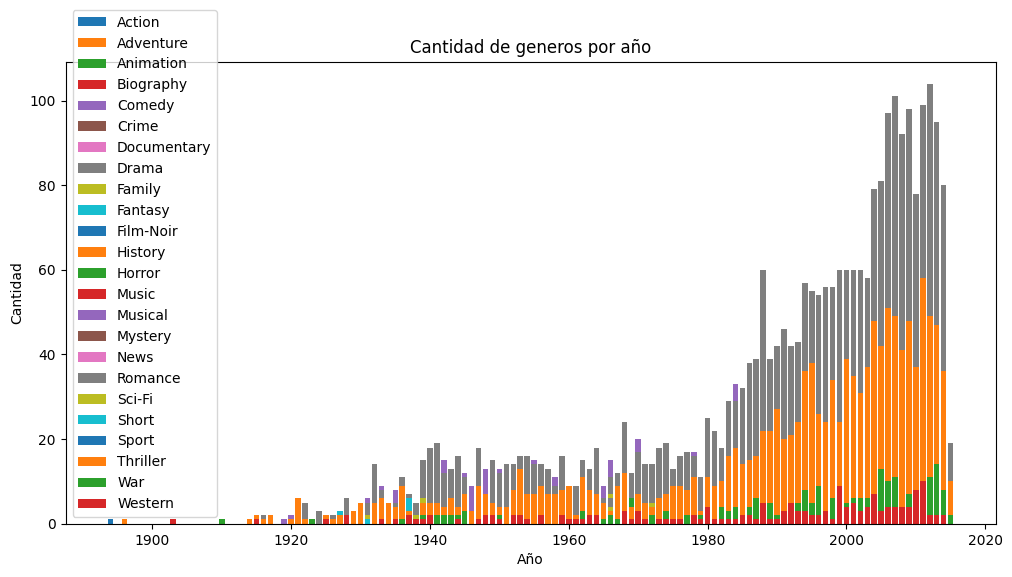

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Agregamos los datos por año, sumando los valores de genero1 y genero2
df_agregado = dfn.groupby('year').sum().reset_index()

# Graficamos los datos
plt.figure(figsize=(12, 6))

# Crear gráficas de barras apiladas

for c in mlb.classes_:
  plt.bar(df_agregado['year'], df_agregado[c], label=c)

# Añadir título y leyenda
plt.title('Cantidad de generos por año')
plt.xlabel('Año')
plt.ylabel('Cantidad')
plt.legend()

# Mostrar el gráfico
plt.show()


In [ ]:
pd.options.display.max_rows = 100

In [ ]:
dfn.groupby('year').sum()[['Drama']]

<ipython-input-19-2e8f2fb76cb4>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dfn.groupby('year').sum()[['Drama']]


,Drama
year,
1894,1.0
1896,1.0
1903,1.0
1910,0.0
1914,1.0
...,...
2011,99.0
2012,104.0
2013,95.0


## Bert model

In [10]:
# Utilizamos un tokenizador del modelo que vamos a usar
# BERT (Bidirectional Encoder Representations from Transformers). https://huggingface.co/bert-base-uncased
# Se utiliza para convertir los textos de entrada en representaciones numéricas que el modelo BERT pueda entender
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased") # ❓Tal vez probar con RoBERTa o XLNet?

# Preparamos los inputs para el modelo
inputs = tokenizer(X_train['X'].to_list(), return_tensors='tf', truncation=True, padding=True)
# inputs_eval = tokenizer(X_test.to_list(), return_tensors='tf', truncation=True, padding=True)

# Cargamos el modelo pre-entrenado
bert_model = TFAutoModel.from_pretrained("bert-base-uncased")

# Congelamos el modelo pre-entrenado
# Esto significa que los pesos del modelo no se actualizarán durante el entrenamiento. Al congelar el modelo, se utiliza como una capa de extracción de características fijas en lugar de entrenarlo desde cero. Esta es una práctica común cuando se utiliza la transferencia de aprendizaje con modelos pre-entrenados.
bert_model.trainable = False

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# Creamos la red neuronal
input_ids = tf.keras.layers.Input(shape=(inputs['input_ids'].shape[1],), dtype=tf.int32)
token_type_ids = tf.keras.layers.Input(shape=(inputs['token_type_ids'].shape[1],), dtype=tf.int32)
attention_mask = tf.keras.layers.Input(shape=(inputs['attention_mask'].shape[1],), dtype=tf.int32)
embedding = bert_model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]


# La indexación [:, 0, :] se utiliza para obtener solo la representación del token especial [CLS] del modelo BERT, que se utiliza a menudo como representación resumida del texto.
# hidden1 = tf.keras.layers.Dropout(0.5)(embedding[:, 0, :])
# hidden2 =  tf.keras.layers.Dense(48, activation='relu')(embedding[:, 0, :])
# hidden3 = tf.keras.layers.Dropout(0.5)(hidden2)
# output = tf.keras.layers.Dense(len(mlb.classes_), activation='sigmoid')(hidden3)
output = tf.keras.layers.Dense(len(mlb.classes_), activation='sigmoid')(embedding[:, 0, :])

# Compilamos el modelo
model = tf.keras.Model(
          inputs=[input_ids, token_type_ids, attention_mask],
          outputs=output
        )
model.compile(loss='binary_crossentropy', optimizer='adam')

# Finalmente, entrenamos el modelo
result = model.fit(
    [inputs['input_ids'], inputs['token_type_ids'], inputs['attention_mask']], y_train,
    epochs=28, batch_size=30
  )


Epoch 1/28
264/264 [==============================] - 123s 408ms/step - loss: 0.2794
Epoch 2/28
264/264 [==============================] - 108s 409ms/step - loss: 0.2314
Epoch 3/28
264/264 [==============================] - 108s 408ms/step - loss: 0.2168
Epoch 4/28
264/264 [==============================] - 108s 408ms/step - loss: 0.2095
Epoch 5/28
264/264 [==============================] - 108s 408ms/step - loss: 0.2056
Epoch 6/28
264/264 [==============================] - 108s 409ms/step - loss: 0.2014
Epoch 7/28
264/264 [==============================] - 108s 409ms/step - loss: 0.1990
Epoch 8/28
264/264 [==============================] - 108s 409ms/step - loss: 0.1968
Epoch 9/28
264/264 [==============================] - 108s 409ms/step - loss: 0.1949
Epoch 10/28
264/264 [==============================] - 108s 408ms/step - loss: 0.1938
Epoch 11/28
264/264 [==============================] - 108s 408ms/step - loss: 0.1923
Epoch 12/28
264/264 [==============================] - 108s 408

In [ ]:
result = model.fit(
    [inputs['input_ids'], inputs['token_type_ids'], inputs['attention_mask']], encoded_genres,
    epochs=1, batch_size=30
  )

264/264 [==============================] - 108s 410ms/step - loss: 0.1835


In [11]:
from sklearn.metrics import roc_curve, auc
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

def showAucs(clf, tokenizer, X_test, y_test):
  # Tokenize the new data
  new_inputs = tokenizer(X_test.tolist(), return_tensors='tf', truncation=True, padding=True)
  y_score = clf.predict([new_inputs['input_ids'], new_inputs['token_type_ids'], new_inputs['attention_mask']])

  # Calculamos la curva ROC para cada clase
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(24):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

  return pd.DataFrame({'Genero': cols, 'AUC': roc_auc.values()}).sort_values(['AUC'], ascending=False)

In [ ]:
aucs_bert = showAucs(model, tokenizer, X_test, y_test)


99/99 [==============================] - 41s 380ms/step


In [ ]:
aucs_bert

,Genero,AUC
16,p_News,0.999049
6,p_Documentary,0.987340
23,p_Western,0.986199
22,p_War,0.969116
20,p_Sport,0.962573
2,p_Animation,0.954736
18,p_Sci-Fi,0.946402
19,p_Short,0.942211
11,p_History,0.936720
12,p_Horror,0.930802


In [13]:
dft = dataTesting.copy()
dft['plot'] = dft['plot'].apply(lambda x: x.lower())
dft['title'] = dft['title'].apply(lambda x: x.lower())
dft['X'] = '<title>' + dft['title'] + '</titulo> <plot> ' + dft['plot'] + '</plot>'

In [ ]:
dataTesting

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...
...,...,...,...
11263,2008,The Fifth Commandment,"in bangkok , an assassin who turns down a job..."
11265,2003,Coffee and Cigarettes,eleven separate vignettes are presented . in ...
11269,1957,Pal Joey,"joey evans is charming , handsome , funny , ..."
11270,2002,Jonah: A VeggieTales Movie,when the singing veggies encounter some car tr...


In [ ]:

# Tokenize the new data
new_inputs = tokenizer(dft['p'].to_list(), return_tensors='tf', truncation=True, padding=True)

# Use the model to predict the genres
new_predictions = model.predict([new_inputs['input_ids'], new_inputs['token_type_ids'], new_inputs['attention_mask']])



106/106 [==============================] - 40s 378ms/step


In [ ]:


# Predicción del conjunto de test
y_pred_test_genres = new_predictions

# Guardar predicciones en formato exigido en la competencia de kaggle
res = pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols)
# display(res)
res.to_csv('./bert-with-title-split.csv', index_label='ID')

In [ ]:
model.save_weights('bert-with-title.h5')

### Refinamiento

In [ ]:
aucs_bert

,Genero,AUC
16,p_News,1.000000
23,p_Western,0.995479
6,p_Documentary,0.993569
20,p_Sport,0.991447
22,p_War,0.979888
2,p_Animation,0.970536
19,p_Short,0.969283
18,p_Sci-Fi,0.968044
10,p_Film-Noir,0.967480
13,p_Music,0.961128


In [ ]:
removed_classes = aucs_bert[aucs_bert['AUC'] > 0.94]
removed_classes.index

Int64Index([16, 23, 6, 20, 22, 2, 19, 18, 10, 13, 8, 12, 11, 3], dtype='int64')

In [ ]:
a = aucs_bert.sort_index()
b = aucs_bert2.sort_index()

a['g2'] = b['Genero']
a['a2'] = b['AUC']
a['result'] = b['AUC'] > a['AUC']
a['diff'] = b['AUC'] - a['AUC']
a

,Genero,AUC,g2,a2,result,diff
0,p_Action,0.925865,p_Action,0.914625,False,-0.011240
1,p_Adventure,0.933228,p_Adventure,0.929953,False,-0.003275
2,p_Animation,0.970536,p_Animation,0.975147,True,0.004611
3,p_Biography,0.946650,p_Biography,0.955053,True,0.008403
4,p_Comedy,0.874704,p_Comedy,0.875884,True,0.001180
5,p_Crime,0.922382,p_Crime,0.915137,False,-0.007245
6,p_Documentary,0.993569,p_Documentary,0.996198,True,0.002629
7,p_Drama,0.834246,p_Drama,0.828196,False,-0.006050
8,p_Family,0.959531,p_Family,0.951650,False,-0.007881
9,p_Fantasy,0.916769,p_Fantasy,0.935166,True,0.018398


In [ ]:
!cp bert-with-title.h5 drive/MyDrive/miad

### Refinamiento 2

In [ ]:
# Utilizamos un tokenizador del modelo que vamos a usar
# BERT (Bidirectional Encoder Representations from Transformers). https://huggingface.co/bert-base-uncased
# Se utiliza para convertir los textos de entrada en representaciones numéricas que el modelo BERT pueda entender
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased") # ❓Tal vez probar con RoBERTa o XLNet?

# Preparamos los inputs para el modelo
inputs = tokenizer(X_test['X'].to_list(), return_tensors='tf', truncation=True, padding=True)
# inputs_eval = tokenizer(X_test.to_list(), return_tensors='tf', truncation=True, padding=True)

# Cargamos el modelo pre-entrenado
bert_model = TFAutoModel.from_pretrained("bert-base-uncased")

# Congelamos el modelo pre-entrenado
# Esto significa que los pesos del modelo no se actualizarán durante el entrenamiento. Al congelar el modelo, se utiliza como una capa de extracción de características fijas en lugar de entrenarlo desde cero. Esta es una práctica común cuando se utiliza la transferencia de aprendizaje con modelos pre-entrenados.
bert_model.trainable = False

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
cat_done = pd.read_csv('/content/drive/MyDrive/miad/bert-1.csv')
c_remove = cat_done.columns[1:]
c_remove

Index(['p_News', 'p_Western', 'p_Documentary', 'p_Sport', 'p_War',
       'p_Animation', 'p_Short', 'p_Sci-Fi', 'p_Music', 'p_History',
       'p_Film-Noir', 'p_Horror', 'p_Family', 'p_Biography'],
      dtype='object')

In [ ]:
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

In [ ]:

cols2 = [c for c in cols if c not in c_remove]
cols2

['p_Action',
 'p_Adventure',
 'p_Comedy',
 'p_Crime',
 'p_Drama',
 'p_Fantasy',
 'p_Musical',
 'p_Mystery',
 'p_Romance',
 'p_Thriller']

In [ ]:
genres_df = pd.DataFrame(y_test, columns=cols)
genres_arr = genres_df[cols2].to_numpy()

# Calcula las frecuencias de clase
class_frequencies = np.sum(genres_arr, axis=0)

# Calcula los pesos inversos al logaritmo de la frecuencia de clase
weights = 1 / np.log(1 + class_frequencies)

class_weights = tf.constant(weights.astype('float32'), dtype=tf.float32)

def weighted_loss(y_true, y_pred):
    per_example_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred)
    weighted_loss = tf.reduce_mean(tf.multiply(class_weights, per_example_loss))
    return weighted_loss


In [ ]:
import tensorflow as tf


# Creamos la red neuronal
input_ids = tf.keras.layers.Input(shape=(inputs['input_ids'].shape[1],), dtype=tf.int32)
token_type_ids = tf.keras.layers.Input(shape=(inputs['token_type_ids'].shape[1],), dtype=tf.int32)
attention_mask = tf.keras.layers.Input(shape=(inputs['attention_mask'].shape[1],), dtype=tf.int32)
embedding = bert_model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]

# Agregar capas adicionales para clasificación
x = tf.keras.layers.GlobalAveragePooling1D()(embedding)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
output = tf.keras.layers.Dense(len(cols2), activation='sigmoid')(x)
# output = tf.keras.layers.Dense(len(cols2), activation='sigmoid')(embedding[:, 0, :])

# Crear el modelo
model = tf.keras.Model(
      inputs=[input_ids, token_type_ids, attention_mask],
      outputs=output
    )

# Compilar el modelo
model.compile(loss='binary_crossentropy', optimizer='adam')




In [ ]:
# Entrenar el modelo
hist = model.fit(
    [inputs['input_ids'], inputs['token_type_ids'], inputs['attention_mask']], genres_arr,
    epochs=20,  # Ajustar el número de épocas según tus necesidades
    batch_size=20,  # Ajustar el tamaño del lote según tus necesidades
)

Epoch 1/20
395/395 [==============================] - 62s 118ms/step - loss: 0.3697
Epoch 2/20
395/395 [==============================] - 47s 118ms/step - loss: 0.3322
Epoch 3/20
395/395 [==============================] - 47s 118ms/step - loss: 0.3240
Epoch 4/20
395/395 [==============================] - 47s 118ms/step - loss: 0.3202
Epoch 5/20
395/395 [==============================] - 47s 118ms/step - loss: 0.3169
Epoch 6/20
395/395 [==============================] - 47s 118ms/step - loss: 0.3131
Epoch 7/20
395/395 [==============================] - 47s 118ms/step - loss: 0.3112
Epoch 8/20
395/395 [==============================] - 47s 118ms/step - loss: 0.3094
Epoch 9/20
395/395 [==============================] - 47s 118ms/step - loss: 0.3070
Epoch 10/20
395/395 [==============================] - 47s 118ms/step - loss: 0.3056
Epoch 11/20
395/395 [==============================] - 47s 118ms/step - loss: 0.3042
Epoch 12/20
395/395 [==============================] - 47s 118ms/step - lo

In [ ]:


aucs_bert = showAucs(model, tokenizer, X_test, genres_arr)

99/99 [==============================] - 14s 145ms/step


In [ ]:
aucs_bert

,Genero,AUC
6,p_Musical,0.960858
5,p_Fantasy,0.949851
1,p_Adventure,0.948395
0,p_Action,0.945334
3,p_Crime,0.944272
7,p_Mystery,0.926436
9,p_Thriller,0.909353
2,p_Comedy,0.906353
8,p_Romance,0.897373
4,p_Drama,0.869470


In [ ]:
# Assume new_data is your new plot description(s) as a list
new_data = dataTesting['plot'].to_list()

# Tokenize the new data
new_inputs = tokenizer(new_data, return_tensors='tf', truncation=True, padding=True)

# Use the model to predict the genres
new_predictions = model.predict([new_inputs['input_ids'], new_inputs['token_type_ids'], new_inputs['attention_mask']])



106/106 [==============================] - 15s 144ms/step


In [ ]:
# Predicción del conjunto de test
y_pred_test_genres = new_predictions

# Guardar predicciones en formato exigido en la competencia de kaggle
res = pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols2)
# display(res)
res.to_csv('/content/drive/MyDrive/miad/bert-2.csv', index_label='ID')

In [ ]:
c_remove = aucs_bert[aucs_bert['AUC'] > 0.94]['Genero']
c_no_remove = aucs_bert[aucs_bert['AUC'] <= 0.94]['Genero']

In [ ]:
res[c_remove.to_list()].to_csv('/content/drive/MyDrive/miad/bert-part-2.csv', index_label='ID')

**tercer refinamiento**

In [ ]:
c_no_remove = ['p_Mystery', 'p_Thriller', 'p_Comedy', 'p_Romance', 'p_Drama']

In [ ]:
genres_df = pd.DataFrame(y_train, columns=cols)
genres_arr = genres_df[c_no_remove].to_numpy()

In [ ]:
inputs = tokenizer(df['X'].to_list(), return_tensors='tf', truncation=True, padding=True)
bert_model = TFAutoModel.from_pretrained("bert-base-uncased")
bert_model.trainable = False

# Creamos la red neuronal
input_ids = tf.keras.layers.Input(shape=(inputs['input_ids'].shape[1],), dtype=tf.int32)
token_type_ids = tf.keras.layers.Input(shape=(inputs['token_type_ids'].shape[1],), dtype=tf.int32)
attention_mask = tf.keras.layers.Input(shape=(inputs['attention_mask'].shape[1],), dtype=tf.int32)
embedding = bert_model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]

# Agregar capas adicionales para clasificación
x = tf.keras.layers.GlobalAveragePooling1D()(embedding)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)  # Aumentar el número de unidades
x = tf.keras.layers.Dense(256, activation='relu')(x)
output = tf.keras.layers.Dense(len(c_no_remove), activation='sigmoid')(x)


# Crear el modelo
model = tf.keras.Model(
      inputs=[input_ids, token_type_ids, attention_mask],
      outputs=output
    )

# Compilar el modelo
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
hist = model.fit(
    [inputs['input_ids'], inputs['token_type_ids'], inputs['attention_mask']], genres_arr,
    epochs=36, # Se aumenta epochs
    batch_size=32,  # Aumentar el tamaño del lote
)

In [ ]:
model.save_weights('/content/drive/MyDrive/miad/bert-with-title-3.h5')

In [ ]:
aucs_bert = showAucs(model, tokenizer, df['X'], genres_arr)
aucs_bert

99/99 [==============================] - 18s 146ms/step


,Genero,AUC
0,p_Mystery,0.968751
4,p_Romance,0.961483
3,p_Romance,0.961481
1,p_Thriller,0.948164
2,p_Comedy,0.946886


In [27]:
def save(model, tokenizer, name, cols):
  new_data = dft['X'].to_list()
  new_inputs = tokenizer(new_data, return_tensors='tf', truncation=True, padding=True)
  year_train = dft['year'].to_numpy().reshape(-1, 1) / 100.0 

  new_predictions = model.predict([new_inputs['input_ids'], new_inputs['token_type_ids'], new_inputs['attention_mask'], year_train])
  
  res = pd.DataFrame(new_predictions, index=dataTesting.index, columns=cols)
  res.to_csv(f'/content/drive/MyDrive/miad/{name}.csv', index_label='ID')


### Definitivo

In [20]:
inputs = tokenizer(df['X'].to_list(), return_tensors='tf', truncation=True, padding=True)
bert_model = TFAutoModel.from_pretrained("bert-base-uncased")
bert_model.trainable = False

# Creamos la red neuronal
input_ids = tf.keras.layers.Input(shape=(inputs['input_ids'].shape[1],), dtype=tf.int32)
token_type_ids = tf.keras.layers.Input(shape=(inputs['token_type_ids'].shape[1],), dtype=tf.int32)
attention_mask = tf.keras.layers.Input(shape=(inputs['attention_mask'].shape[1],), dtype=tf.int32)

# Nueva capa de entrada para la columna "Year"
year_input = tf.keras.layers.Input(shape=(1,), dtype=tf.float32)

embedding = bert_model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]

# Agregar capas adicionales para clasificación
x = tf.keras.layers.GlobalAveragePooling1D()(embedding)

# Combina la salida de BERT con la entrada "Year"
x = tf.keras.layers.Concatenate()([x, year_input])

x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)  # Aumentar el número de unidades
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
output = tf.keras.layers.Dense(len(cols), activation='sigmoid')(x)


# Crear el modelo
model = tf.keras.Model(
      inputs=[input_ids, token_type_ids, attention_mask, year_input],
      outputs=output
    )

# Compilar el modelo
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
model.load_weights('/content/drive/MyDrive/miad/bert-with-title-year.h5')

In [17]:
# Extraemos las características 'Year' y las normalizamos
year_train = df['year'].to_numpy().reshape(-1, 1) / 100.0  # reemplazar 100.0 por el valor de normalización que estés usando

In [21]:
hist = model.fit(
    [inputs['input_ids'], inputs['token_type_ids'], inputs['attention_mask'], year_train], y_train,
    epochs=30, # Se aumenta epochs
    batch_size=32,  # Aumentar el tamaño del lote
)

Epoch 1/30
247/247 [==============================] - 58s 178ms/step - loss: 0.2618
Epoch 2/30
247/247 [==============================] - 44s 178ms/step - loss: 0.2095
Epoch 3/30
247/247 [==============================] - 44s 178ms/step - loss: 0.1990
Epoch 4/30
247/247 [==============================] - 44s 178ms/step - loss: 0.1954
Epoch 5/30
247/247 [==============================] - 44s 178ms/step - loss: 0.1921
Epoch 6/30
247/247 [==============================] - 44s 178ms/step - loss: 0.1901
Epoch 7/30
247/247 [==============================] - 44s 178ms/step - loss: 0.1874
Epoch 8/30
247/247 [==============================] - 44s 178ms/step - loss: 0.1859
Epoch 9/30
247/247 [==============================] - 44s 178ms/step - loss: 0.1854
Epoch 10/30
247/247 [==============================] - 44s 178ms/step - loss: 0.1843
Epoch 11/30
247/247 [==============================] - 44s 178ms/step - loss: 0.1830
Epoch 12/30
247/247 [==============================] - 44s 178ms/step - lo

In [22]:
model.save_weights('/content/drive/MyDrive/miad/bert-with-title-year-2.h5')

In [28]:
save(model, tokenizer, 'bert-full-year-2', cols)

106/106 [==============================] - 19s 146ms/step


In [30]:
showAucs(model, tokenizer, X_test, y_test=)

99/99 [==============================] - 14s 145ms/step


,Genero,AUC
16,p_News,1.000000
23,p_Western,0.997642
20,p_Sport,0.997552
6,p_Documentary,0.997305
22,p_War,0.992760
19,p_Short,0.988051
18,p_Sci-Fi,0.981576
2,p_Animation,0.980285
10,p_Film-Noir,0.978515
12,p_Horror,0.973528


In [ ]:
!pip install sinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 3.8 MB/s eta 0:00:00
  Created wheel for sinfo: filename=sinfo-0.3.4-py3-none-any.whl size=7878 sha256=3550a40ec73a0e1b8a36fec698e92b7a57f84f4db4a95c2630a20088b5546db7
  Stored in directory: /root/.cache/pip/wheels/ae/fe/9d/eb4b47396d5c94b8ad82a5aa9f905c56c981deb4e532329f72
Successfully built sinfo


In [ ]:
from sinfo import sinfo
sinfo()

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
numpy               1.22.4
pandas              1.5.3
sinfo               0.3.4
sklearn             1.2.2
tensorflow          2.12.0
transformers        4.29.2
-----
IPython             7.34.0
jupyter_client      6.1.12
jupyter_core        5.3.0
notebook            6.4.8
-----
Python 3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]
Linux-5.15.107+-x86_64-with-glibc2.31
2 logical CPU cores, x86_64
-----
Session information updated at 2023-05-28 00:14
